# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.svm import SVR

import statsmodels.api as sm

%matplotlib inline
plt.style.use('fivethirtyeight')

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 0. Have Knowledge of data and Clean

### 0.0 id dictionary

In [94]:
def id_mapper_dict():
    """
    In order to create a id dictionary
    1.  customer_id
    2.  offer_type_id
    3. merge all
    """
    # customer_id
    coded_dict = dict()
    cter = 1
    prefix = "C_"
    customer_encoded = []
    
    for val in profile['id']:
        if val not in coded_dict:
            coded_dict[val] = prefix + str(cter)
            cter+=1
        customer_encoded.append(coded_dict[val])
        
    id_dict = dict(zip(profile['id'], customer_encoded))
    
    # offer_type_id
    coded_dict = dict()
    cter = 1
    prefix = "F_"
    offer_encoded = []
    
    for val in portfolio['id']:
        if val not in coded_dict:
            coded_dict[val] = prefix + str(cter)
            cter+=1
        offer_encoded.append(coded_dict[val])
    offer_id_dict = dict(zip(portfolio['id'], offer_encoded))
    
    # merge dictionary
    id_dict.update(offer_id_dict)
    
    return id_dict
id_dict = id_mapper_dict()

## 0.1. Table of portfolio

### 0.1.1. Data Assess

In [95]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


**Notes:**

- id: offer_type id, the primary key of the table 
- offer_type: there are 3 main and 10 sub offer types
- difficulty: thredhold
- reward: if accumulated consumptions over the threshold after received the offer and consuming during the valid date. 

### 0.1.2 Data Clean

- To convert offer_type to unique type like (offer_type)\_difficulty_duration_reward
- extract channels

In [96]:
portfolio['id'] = portfolio['id'].map(id_dict)

In [97]:
for element in ["web", "email", "mobile", "social"]:
    portfolio[element] = portfolio['channels'].apply(lambda x: 1 if element in x else 0)
portfolio.drop('channels', axis=1, inplace=True)

In [98]:
portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,10,7,bogo,F_1,0,1,1,1
1,10,10,5,bogo,F_2,1,1,1,1
2,0,0,4,informational,F_3,1,1,1,0
3,5,5,7,bogo,F_4,1,1,1,0
4,5,20,10,discount,F_5,1,1,0,0
5,3,7,7,discount,F_6,1,1,1,1
6,2,10,10,discount,F_7,1,1,1,1
7,0,0,3,informational,F_8,0,1,1,1
8,5,5,5,bogo,F_9,1,1,1,1
9,2,10,7,discount,F_10,1,1,1,0


## 0.2. Table of profile

### 0.2.1 Data Assess

In [99]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [100]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


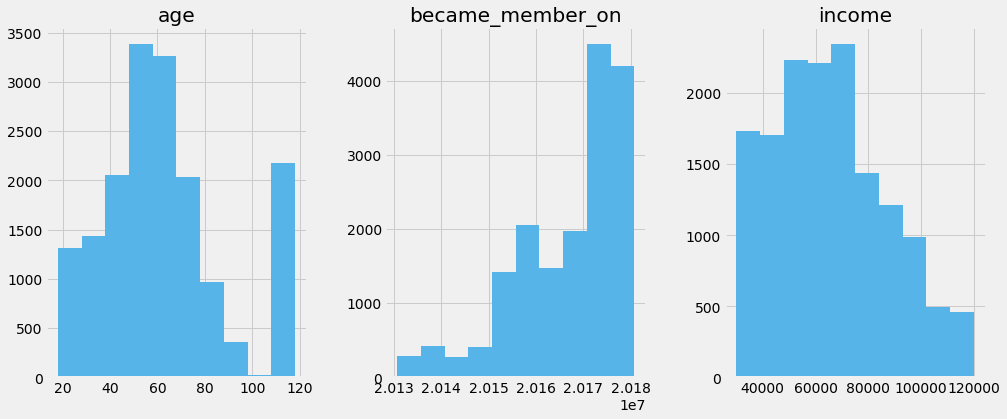

In [101]:
profile.hist(figsize=(15,6), layout=(1,3), color=sns.color_palette('colorblind')[-1], grid=True);
plt.savefig('./pic/profile_distribution.png', dpi=300, quality=80, bbox_inches='tight')

In [102]:
profile[profile['income']<40000].shape[0]/profile.shape[0]

0.11411764705882353

**Notes:**

- id: customor id, primary key
- customers who leave blank age and gender are all 118 years old.
- age might be classified into categories as (,30],(30,45],(45,60],(60,]
- became_member_on might be classified into (,2014],(2014,2015],(2015,2016],(2016,2017](2017,2018],(2018,]
- income might be classifed into 5 categories.

### 0.2.2 Data Clean

- delet invalid records
- create proxies of customer rather than code

In [103]:
# slice
profile = profile[profile['income'].notnull()].reset_index(drop=True)

# create ordinary/categorical data
profile['age'] = pd.cut(x = profile['age'], 
                               bins = [profile['age'].min(), 30, 45, 60, 80,profile['age'].max()],
                               labels = ['<30','31~45','46~60','61~80','>80'])

profile['became_member_on'] = pd.cut(profile['became_member_on'], 
          bins=[profile['became_member_on'].min(), 20150000, 20160000,20170000, 20180000, profile['became_member_on'].max()], 
          labels = ['<2014','2014','2015','2017','2018'])

# convert id 
profile['id'] = profile['id'].map(id_dict)

In [104]:
    profile.head()

,gender,age,id,became_member_on,income
0,F,46~60,C_2,2017,112000.0
1,F,61~80,C_4,2017,100000.0
2,M,61~80,C_6,2018,70000.0
3,M,61~80,C_9,2018,53000.0
4,M,46~60,C_13,2017,51000.0


## 0.3. Table of transcript

### 0.3.1 Data Assess

In [105]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [106]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [107]:
transcript['event'].unique().tolist()

['offer received', 'offer viewed', 'transaction', 'offer completed']

In [108]:
transcript['time'].max()

714

**Notes**

- the designed procedure should be:  
    - offer_received --> offer_veiwed --> transaction --> offer completed

- it's better to seprete the table of transcript into 4 tables refering to 4 events .

- value should be extracted from dictionary.

### 0.3.2 Data Clean

- extract values from dictionary 
- transfer code of person and offer types to short labels.
- seperate the table of transcript into 4 tables. They are offer_received, offer_viewed, offer_completed, and transcation.

In [109]:
# extract values from dictionary
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0])

# map the columns of person and value from id_dict
transcript['person'] = transcript['person'].map(id_dict)
transcript.loc[transcript["event"] != 'transaction',"value"] = transcript.loc[transcript["event"] != 'transaction',"value"].map(id_dict)

In [110]:
# seperate the table of transcript into 4 tables. They are offer_received, offer_viewed, offer_completed, and transcation. 
# and rename the columns respectively. 
offer_received = transcript.query("event == 'offer received'").loc[:,['person','time','value']]
offer_received.columns = ['person','received_time','received_offer']

offer_viewed = transcript.query("event == 'offer viewed'").loc[:,['person','time','value']]
offer_viewed.columns = ['person','viewed_time','viewed_offer']

transaction = transcript.query("event == 'transaction'").loc[:, ['person','time','value']]
transaction.columns = ['person','purchase_time','amount']
transaction['amount'] = transaction['amount'].astype(float)

offer_completed = transcript.query("event == 'offer completed'").loc[:, ['person','time','value']]
offer_completed.columns =  ['person','completed_time','completed_offer']

## 0.4 Summary

In [111]:
q1 = transcript['person'].nunique()
q2 = offer_received['person'].nunique()
q3 = q1 - q2
q4 = offer_completed['person'].nunique()
q5 = len(set(offer_received['person']) - set(transaction['person']))
q6 = offer_viewed['person'].nunique()
q7 = len(set(set(offer_received['person']) - set(offer_viewed['person'])) - set(transaction['person']))

In [112]:
print("""
There are %d customers contained in the simulated data set. Only these person who received offers and completes the offers would be awarded. 
%d person received offers while %d person did not. Each person might receive several types of offer, %d person at least completed an offer and were rewarded. %d person received offers but did not have any consumption records. %d person did not view any offers they received. However, 
only %d person in them with no transaction records.\n
%d person who had not any transaction records are out of the range of this observation.
""" % (q1,q2,q3,q4,q5,q6,q7,q3))


There are 17000 customers contained in the simulated data set. Only these person who received offers and completes the offers would be awarded. 
16994 person received offers while 6 person did not. Each person might receive several types of offer, 12774 person at least completed an offer and were rewarded. 422 person received offers but did not have any consumption records. 16834 person did not view any offers they received. However, 
only 10 person in them with no transaction records.

6 person who had not any transaction records are out of the range of this observation.



# 1. To indentify customers who are responsive to coffee offers

## 1.1 Criteria for response record

- a customer who received the offer viewed the offer and completed the offer.
- a customer might received offers for several times, but the offers have to be viewed and complete in time.
- the offer type of informational is slightly different to the other offer types. There isn't a sign of completion so that we assume if any comsumption occurs after viewed during validity of date might be account for a qualified response record.

## 1.2 Create a response dataframe

### 1.2.1 seperate bogo, discount and informational

In [113]:
# offer_received_without_informational 
offer_bogo_discount = offer_received.query("not(received_offer == 'F_3' or received_offer == 'F_8')")
offer_informational = offer_received.query("received_offer == 'F_3' or received_offer == 'F_8'")

### 1.2.1 find response for bogo and discount offer

In [114]:
# prepare
response = offer_bogo_discount.merge(portfolio[['id','duration']], left_on='received_offer', right_on = 'id')
response.drop('id', axis=1, inplace=True)

# connect received offers and viewed offers
response = response.merge(offer_viewed, left_on = ['person','received_offer'], right_on = ['person', 'viewed_offer'])
response['isValid'] = ((response['viewed_time'] - response['received_time']) <= response['duration']) & \
                                ((response['viewed_time'] - response['received_time'] >= 0))
response = response.loc[response['isValid'], :"duration"]

# connect viewed offers and completed offers
response = response.merge(offer_completed, left_on = ['person','received_offer'], right_on = ['person', 'completed_offer'])
response['isValid'] = ((response['completed_time'] - response['received_time']) <= response['duration']) & \
                                ((response['completed_time'] - response['received_time'] >= 0))
response = response.loc[response['isValid'], :"received_offer"]

In [115]:
response['person'].nunique()

1531

In [116]:
response.head()

,person,received_time,received_offer
2,C_175,0,F_4
17,C_982,168,F_4
28,C_2283,0,F_4
35,C_2611,0,F_4
41,C_2894,0,F_4


### 1.2.2 find responses for informational offer

In [117]:
# prepare
response_info = offer_informational.merge(portfolio[['id','duration']], left_on='received_offer', right_on = 'id')
response_info.drop('id', axis=1, inplace=True)

# connect received offers and viewed offers
response_info = response_info.merge(offer_viewed, left_on = ['person','received_offer'], right_on = ['person', 'viewed_offer'])
response_info['isValid'] = ((response_info['viewed_time'] - response_info['received_time']) <= response_info['duration']) & \
                                ((response_info['viewed_time'] - response_info['received_time'] >= 0))
response_info = response_info.loc[response_info['isValid'], :"duration"]

# connect viewed offers and transaction records
response_info = response_info.merge(transaction, on="person")

def isValid_info(response_info): # valid metric 
    if (response_info['purchase_time'] >= response_info['received_time']) & \
       (response_info['purchase_time'] <= (response_info['received_time'] + response_info['duration'])): 
        return True
    else:
        return False
response_info['isValid'] = response_info.apply(isValid_info, axis=1)

response_info = response_info[response_info['isValid']].groupby(['person','received_time','received_offer'])['amount'].sum().reset_index().loc[:,:'received_offer']

### 1.2.3 all response records

In [118]:
# merge 
response = pd.concat([response,response_info])

In [119]:
response.head()

,person,received_time,received_offer
2,C_175,0,F_4
17,C_982,168,F_4
28,C_2283,0,F_4
35,C_2611,0,F_4
41,C_2894,0,F_4


## 1.3 Q1: What's the response rate?

### 1.3.1 Overall

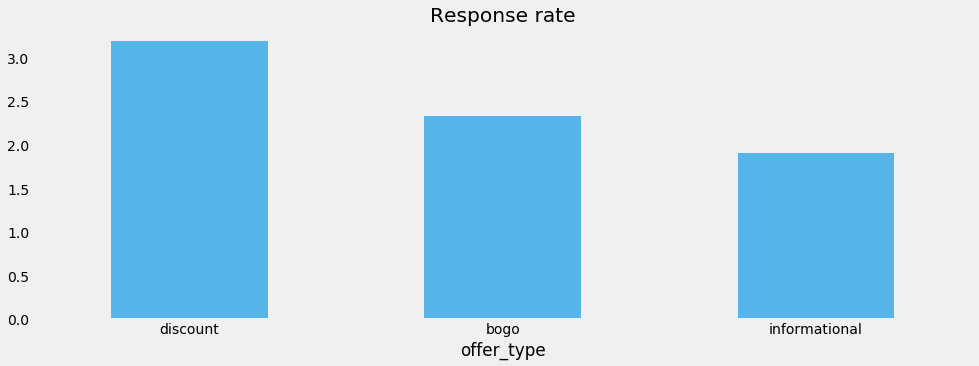

In [120]:
# number of response
stat_response = response.merge(portfolio[['id','offer_type','difficulty','duration','reward']], left_on='received_offer', right_on='id')
stat_response.drop('id', axis=1, inplace=True)

# number of all received offer
stat_all = offer_received.merge(portfolio[['id','offer_type','difficulty','duration','reward']], left_on='received_offer', right_on='id')
stat_all.drop('id', axis=1, inplace=True)

# response rate
((stat_response.groupby('offer_type').size()/stat_all.groupby('offer_type').size())*100).rename("response_rate").\
sort_values(ascending = False).plot.bar(figsize=(15,5), rot=0, title="Response rate",color=sns.color_palette('colorblind')[-1], grid=False);
plt.savefig('./pic/response_rate_overall.png', dpi=300, bbox_inches='tight')

In [121]:
((stat_response.groupby('offer_type').size()/stat_all.groupby('offer_type').size())*100)

offer_type
bogo             2.324666
discount         3.185673
informational    1.910075
dtype: float64

### 1.3.2 subset

In [122]:
response_rate = (stat_response.groupby(['offer_type','difficulty','duration','reward']).size()/stat_all.groupby(['offer_type','difficulty','duration','reward']).size()*100).round(2)

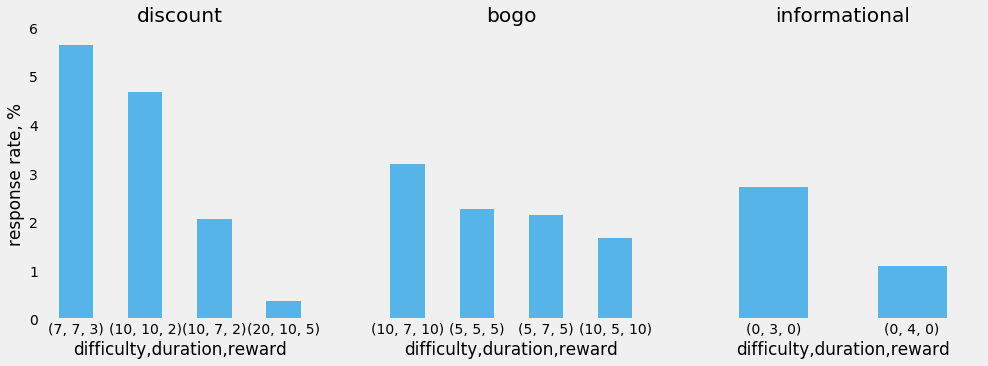

In [123]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(15,5))

idx = pd.IndexSlice
ax1 = response_rate.loc[idx['discount']].sort_values(ascending = False).plot.bar(title='discount', color=sns.color_palette('colorblind')[-1], ax=ax1, rot=0,ylim=(0,6), grid=False)
ax1.set_ylabel("response rate, %")
ax2 = response_rate.loc[idx['bogo']].sort_values(ascending = False).plot.bar(title='bogo', color=sns.color_palette('colorblind')[-1], ax=ax2, rot=0, sharey=True,ylim=(0,6),grid=False)
ax3 = response_rate.loc[idx['informational']].sort_values(ascending = False).plot.bar(title='informational', color=sns.color_palette('colorblind')[-1], ax=ax3,rot=0,sharey=True,ylim=(0,6),grid=False)

plt.savefig('./pic/response_rate_subset.png', bbox_inches='tight', dpi=300)

## 1.4 Which groups of people are most responsive to each type of offer?

In [124]:
response_person = response.drop_duplicates(subset=['person'])
response_person = response_person.merge(profile, left_on='person', right_on = 'id')
response_person.drop('id', axis=1, inplace=True)
response_person = response_person.merge(portfolio[['id','offer_type']], left_on='received_offer', right_on='id')
response_person.drop('id', axis=1, inplace=True)

# convert data of income in profile as category data
response_person['income'] = pd.cut(response_person['income'], 
          bins=[profile['income'].min(), 40000, 60000, 80000,100000, profile['income'].max()], 
          labels = ['<40k', '40k~60k', '60k~80k', '80k~100k', '>100k'])

In [125]:
response_person.head()

,person,received_time,received_offer,gender,age,became_member_on,income,offer_type
0,C_175,0,F_4,M,46~60,2018,60k~80k,bogo
1,C_982,168,F_4,O,46~60,2017,60k~80k,bogo
2,C_2283,0,F_4,F,46~60,2017,60k~80k,bogo
3,C_2611,0,F_4,M,31~45,2014,80k~100k,bogo
4,C_2894,0,F_4,M,46~60,2017,40k~60k,bogo


In [126]:
all_person = offer_received.drop_duplicates('person')
all_person = all_person.merge(profile, left_on='person', right_on='id')
all_person.drop('id', axis=1, inplace=True)
all_person = all_person.merge(portfolio[['id','offer_type']], left_on='received_offer', right_on='id')
all_person.drop('id', axis=1, inplace=True)

# convert data of income as category data
all_person['income'] = pd.cut(all_person['income'], 
          bins=[profile['income'].min(), 40000, 60000, 80000,100000, profile['income'].max()], 
          labels = ['<40k', '40k~60k', '60k~80k', '80k~100k', '>100k'])

In [127]:
all_person.head()

,person,received_time,received_offer,gender,age,became_member_on,income,offer_type
0,C_4,0,F_4,F,61~80,2017,80k~100k,bogo
1,C_30,0,F_4,M,46~60,2014,40k~60k,bogo
2,C_35,0,F_4,M,31~45,2015,<40k,bogo
3,C_43,0,F_4,M,31~45,2018,<40k,bogo
4,C_48,0,F_4,F,46~60,2017,60k~80k,bogo


In [128]:
def profile_plot(key, rot):
    """
    plot demographic difference on key variable bewteen response_person and all_person.  
    
    """
    
    underlying = response_person.groupby(['offer_type', key])['person'].count().groupby(level=0).apply(lambda x: x/x.sum() * 100).round(2)
    overall = all_person.groupby(['offer_type',key])['person'].count().groupby(level=0).apply(lambda x: x/x.sum() * 100).round(2)
    
    profile_invest = pd.DataFrame(underlying.rename('Response')).join(overall.rename('Overall'))
    
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
    idx = pd.IndexSlice
    
    y_limit = round(profile_invest.max().max())+1
    profile_invest .loc[idx['discount']].plot.bar(title="discount",ax=ax1, rot=rot, ylim=(0,y_limit))
    profile_invest .loc[idx['bogo']].plot.bar(title="bogo",ax=ax2, rot=rot,legend=False,ylim=(0, y_limit))
    profile_invest .loc[idx['informational']].plot.bar(title="informational",ax=ax3,rot=rot, legend=False,ylim=(0,y_limit));
    
    file_name = './pic/demograhic_differ_on_' + key + '.png'
    plt.savefig(file_name, bbox_inches='tight', dpi=300)
    
    plt.show()
    

In [129]:
def profile_plot_1(key, rot=0, color=sns.color_palette('colorblind')[-1]):
    """
    plot response rate on key demographic variable for response_person. 
    
    """
    
    underlying = response_person.groupby(['offer_type', key])['person'].count()
    overall = all_person.groupby(['offer_type',key])['person'].count()
    
    profile_invest = ((underlying/overall)*100).rename("response_rate")
    
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
    idx = pd.IndexSlice
    
    y_limit = round(profile_invest.max().max())+1
    profile_invest .loc[idx['discount']].plot.bar(title="discount",ax=ax1, rot=rot, ylim=(0,y_limit), legend=False, color=color,grid=False)
    ax1.set_ylabel("response rate, %")
    profile_invest .loc[idx['bogo']].plot.bar(title="bogo",ax=ax2, rot=rot,legend=False,ylim=(0, y_limit),color=color, grid=False)
    profile_invest .loc[idx['informational']].plot.bar(title="informational",ax=ax3,rot=rot, legend=False,ylim=(0,y_limit),color=color, grid=False);
    
    file_name = './pic/response_rate_on_' + key + '.png'
    plt.savefig(file_name, bbox_inches='tight', dpi=300)
    
    plt.show()
  

### 1.4.1 age

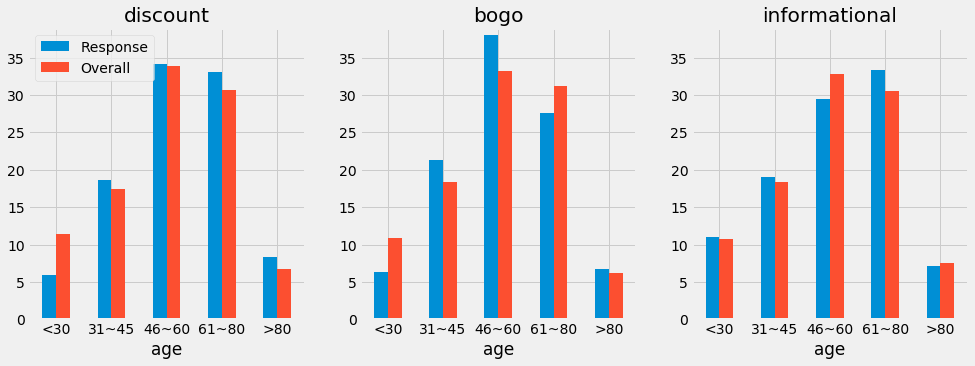

In [130]:
profile_plot('age', 0)

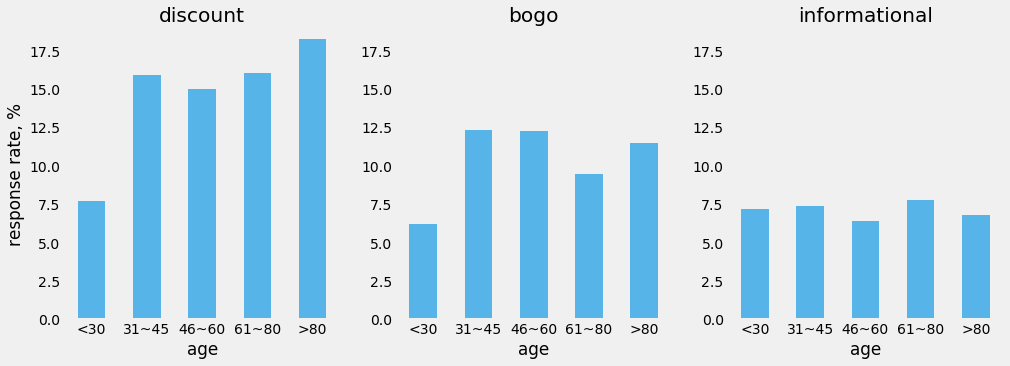

In [131]:
profile_plot_1('age',0)

### 1.4.2 became member on

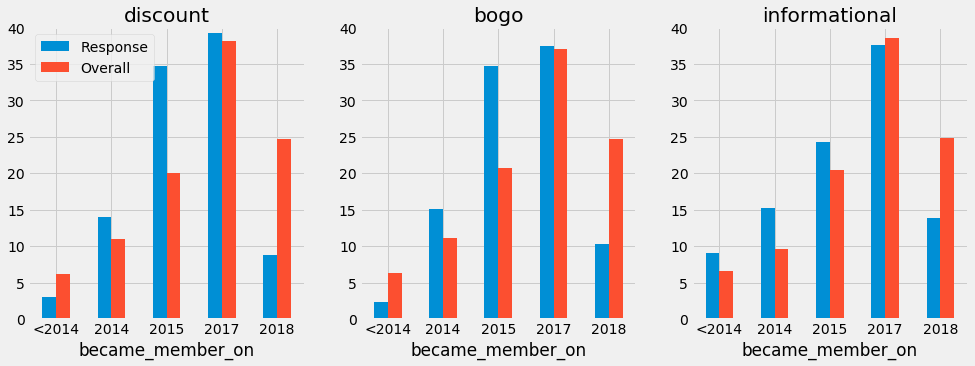

In [132]:
profile_plot('became_member_on',0)

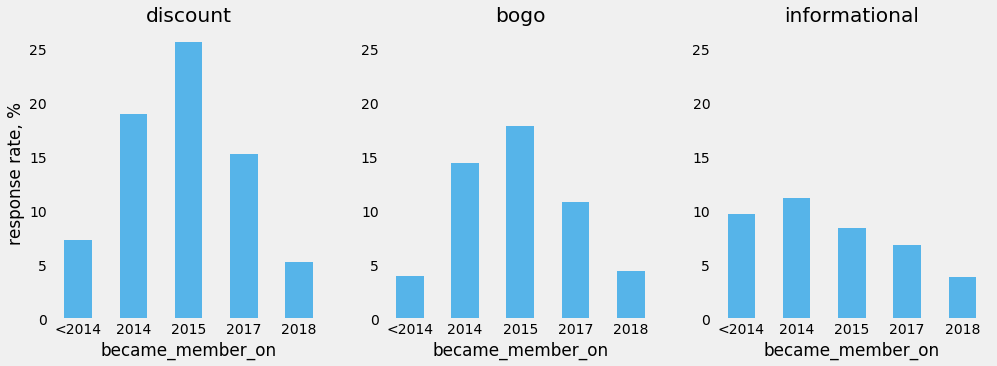

In [133]:
profile_plot_1('became_member_on',0)

### 1.4.3 income

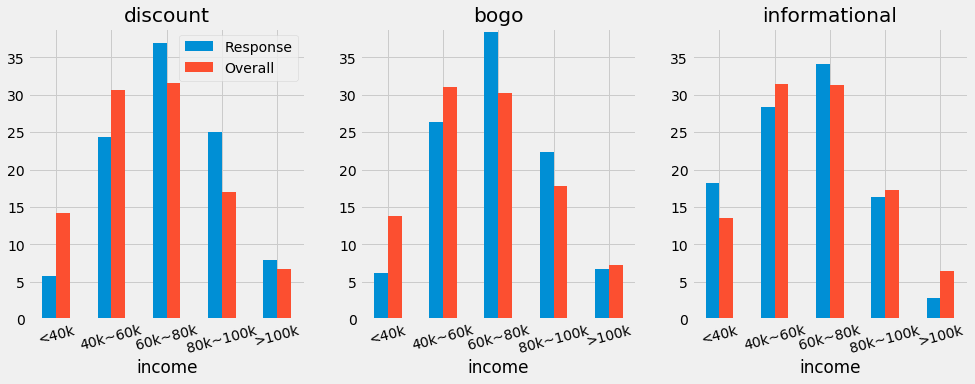

In [134]:
profile_plot('income', 15)

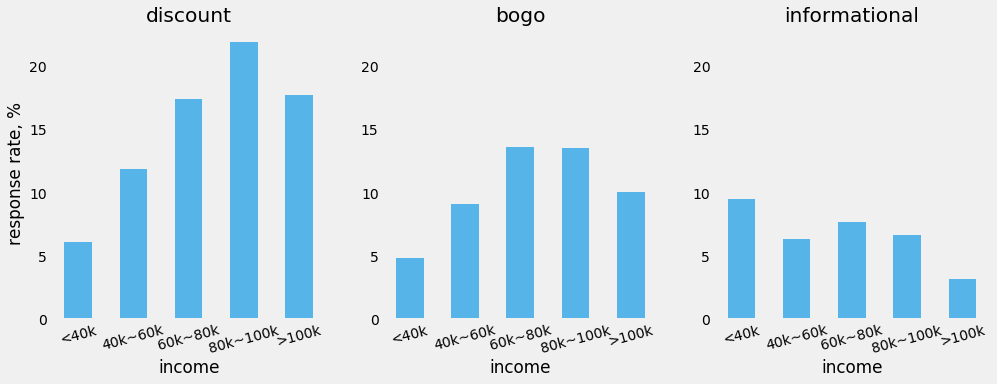

In [135]:
profile_plot_1('income', 15)

# 2. How much someone will spend based on demographics and offer types?

## 2.1 Data Preparation 

- endogenous variable: average amount of purchases
- exogenous variable: including factors of the profiles and offer types and we should know if the customer is responsive to what types of offers. 

### 2.1.1 data set

In [136]:
# merge proflle and response in order to know who is responsive to coffee offers
df = profile.merge(response[['person','received_offer']], left_on='id', right_on='person', how='left')
df.drop('person', axis=1, inplace=True)

# join average transaction data to proflie  
df = df.set_index('id').join(transaction.groupby('person')['amount'].sum(), how="inner")

# drop those customers who didn't receive any coffee offers
exclude_ind = np.array(list(set(transaction['person'])-set(offer_received['person'])))
df = df.iloc[np.where(np.logical_not(np.isin(df.index.values, exclude_ind)))[0]]

**2.1.2 outliers**

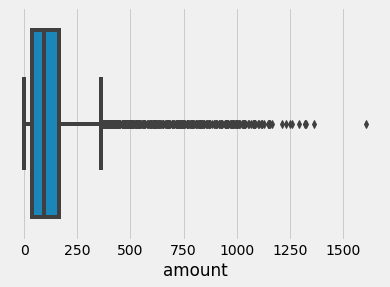

In [137]:
sns.boxplot(x='amount',data=df);

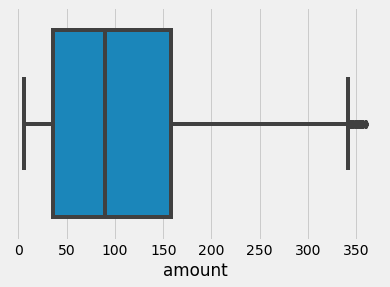

In [138]:
# identify outliers
IQR = df['amount'].quantile(0.75) - df['amount'].quantile(0.25)
outlier = df['amount'].quantile(0.75) + 1.5 * IQR 

# eliminate outliers
df = df[(df['amount'] < outlier) & (df['amount'] > 6) ]
sns.boxplot(x='amount',data=df);

***2.1.3 transformation***

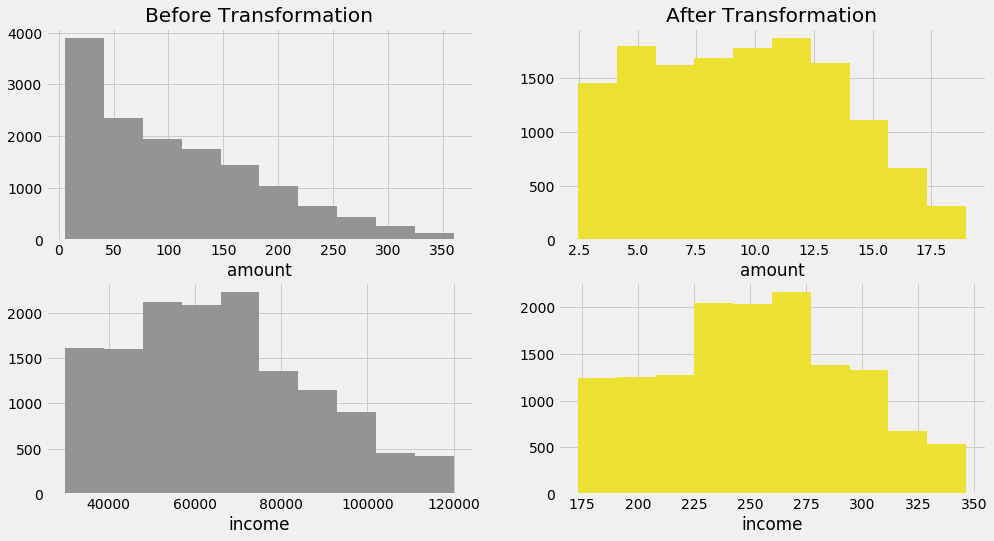

In [139]:
# distribution of amount
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(15,8))
ax1=df['amount'].hist(ax=ax1, color=sns.color_palette('colorblind')[-3])
ax1.set_title('Before Transformation')
ax1.set_xlabel('amount')

ax2=np.sqrt(df['amount']).hist(ax=ax2, color=sns.color_palette('colorblind')[-2])
ax2.set_title('After Transformation')
ax2.set_xlabel('amount')

ax3=df['income'].hist(ax=ax3,color=sns.color_palette('colorblind')[-3])
ax3.set_xlabel('income')

ax4=np.sqrt(df['income']).hist(ax=ax4,color=sns.color_palette('colorblind')[-2])
ax4.set_xlabel('income')

plt.savefig('./pic/reg_distribution.png', bbox_inches='tight', dpi=300)

In [140]:
# data transform
df['amount'] = np.sqrt(df['amount'])
df['income'] = np.sqrt(df['income'])

***2.1.4 transfer categories to dummy variable, and normalize***

In [141]:
# dummy variables
df = pd.get_dummies(df)

# drop 'gender_M', 'gender_O'  , because they aren't indipendent with gender_F
df.drop(['gender_M', 'gender_O'], axis=1, inplace=True)

In [142]:
# normalize scalar
scalar = MinMaxScaler(copy=True, feature_range=(0, 1)).fit(df)
scaled_df = scalar.transform(df)


***2.1.4 split train and test***

In [143]:
y = scaled_df[:,1]
X = np.delete(scaled_df,1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y)

### 2.2 Modeling

### 2.2.1a Linear regression model fitting

In [144]:
# model fit
reg = sm.OLS(y_train,X_train).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.852
Model:                            OLS   Adj. R-squared (uncentered):              0.852
Method:                 Least Squares   F-statistic:                              2728.
Date:                Sun, 16 May 2021   Prob (F-statistic):                        0.00
Time:                        12:30:28   Log-Likelihood:                          2594.3
No. Observations:               10449   AIC:                                     -5145.
Df Residuals:                   10427   BIC:                                     -4985.
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3411      0.008     41.144      0.000       0.325       0.357
x2             0.0548      0.004     14.103      0.000       0.047       0.062
x3             0.0047      0.026      0.180      0.857      -0.046       0.056
x4             0.0259      0.026      1.002      0.316      -0.025       0.077
x5             0.0233      0.026      0.903      0.366      -0.027       0.074
x6             0.0227      0.026      0.879      0.379      -0.028       0.073
x7             0.0093      0.027      0.349      0.727      -0.043       0.061
x8             0.1860      0.026      7.050      0.000       0.134       0.238
x9             0.2793      0.026     10.705      0.000       0.228       0.330
x10            0.3136      0.026     12.078      0.000       0.263       0.364
x11            0.1999      0.026      7.762      0.000       0.149       0.250
x12            0.0821      0.026      3.184      0.001       0.032       0.133
x13            0.2350      0.014     16.248      0.000       0.207       0.263
x14            0.1950      0.019     10.492      0.000       0.159       0.231
x15            0.1764      0.021      8.343      0.000       0.135       0.218
x16            0.1755      0.027      6.606      0.000       0.123       0.228
x17            0.1828      0.018     10.365      0.000       0.148       0.217
x18            0.1748      0.040      4.329      0.000       0.096       0.254
x19            0.1727      0.011     15.559      0.000       0.151       0.195
x20            0.1926      0.013     15.169      0.000       0.168       0.218
x21            0.1043      0.017      6.285      0.000       0.072       0.137
x22            0.1820      0.018     10.112      0.000       0.147       0.217
==============================================================================
Omnibus:                      201.108   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.640
Skew:                           0.330   Prob(JB):                     1.34e-45
Kurtosis:                       2.803   Cond. No.                         44.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 2.2.1b Multi factor regression model

In [145]:
reg = LinearRegression().fit(X_train, y_train)
print((" R2 for train set: %.2f, \n R2 for test set: %.2f")  % (r2_score(y_train,reg.predict(X_train)), r2_score(y_test,reg.predict(X_test))))

 R2 for train set: 0.41, 
 R2 for test set: 0.40


### 2.2.2 Random Forest model

In [146]:
regr = RandomForestRegressor(max_depth=7)
regr.fit(X_train,y_train)
print((" R2 for train set: %.2f, \n R2 for test set: %.2f")  % (r2_score(y_train,regr.predict(X_train)), r2_score(y_test,regr.predict(X_test))))

 R2 for train set: 0.41, 
 R2 for test set: 0.39


### 2.2.3 Supported vector regression

In [147]:
svr = SVR()
svr.fit(X_train, y_train) 
print((" R2 for train set: %.2f, \n R2 for test set: %.2f")  % (r2_score(y_train,svr.predict(X_train)), r2_score(y_test,svr.predict(X_test))))

 R2 for train set: 0.44, 
 R2 for test set: 0.41


### 2.2.4 Results

In [148]:
model_dict={"Linear Regression": [r2_score(y_train,reg.predict(X_train)), r2_score(y_test,reg.predict(X_test))],
                  "Random Forest Regression":  [r2_score(y_train,regr.predict(X_train)), r2_score(y_test,regr.predict(X_test))],
                  "Supported Vector Rregreesion":  [r2_score(y_train,svr.predict(X_train)), r2_score(y_test,svr.predict(X_test))],
           }
pd.DataFrame(model_dict, index=['R2_train', 'R2_test']).round(2)

,Linear Regression,Random Forest Regression,Supported Vector Rregreesion
R2_train,0.41,0.41,0.44
R2_test,0.40,0.39,0.41


## 2.3 Improvement 

In [149]:
# merge proflle and response in order to know who is responsive to coffee offers
df = profile.merge(response[['person','received_offer']], left_on='id', right_on='person', how='left')
df.drop('person', axis=1, inplace=True)

# join average transaction data to proflie  
df = df.set_index('id').join(transaction.groupby('person')['amount'].sum(), how="inner")

# drop those customers who didn't receive any coffee offers
exclude_ind = np.array(list(set(transaction['person'])-set(offer_received['person'])))
df = df.iloc[np.where(np.logical_not(np.isin(df.index.values, exclude_ind)))[0]]

**2.1.4 transfer categories to dummy variable, and normalize**

In [150]:
# dummy variables
df = pd.get_dummies(df)

# drop 'gender_M', 'gender_O'  , because they aren't indipendent with gender_F
df.drop(['gender_M', 'gender_O'], axis=1, inplace=True)

In [151]:
# normalize scalar
scalar = MinMaxScaler(copy=True, feature_range=(0, 1)).fit(df)
scaled_df = scalar.transform(df)

### 2.3.4 split train and test

In [152]:
y = scaled_df[:,1]
X = np.delete(scaled_df,1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y)

## 2.3.5 modeling

### 2.3.5.1 Linear regression model

In [153]:
# model fit
reg = sm.OLS(y_train,X_train).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.574
Model:                            OLS   Adj. R-squared (uncentered):              0.573
Method:                 Least Squares   F-statistic:                              672.3
Date:                Sun, 16 May 2021   Prob (F-statistic):                        0.00
Time:                        12:31:17   Log-Likelihood:                          13370.
No. Observations:               11012   AIC:                                 -2.670e+04
Df Residuals:                   10990   BIC:                                 -2.654e+04
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0902      0.003     28.862      0.000       0.084       0.096
x2             0.0117      0.001      8.125      0.000       0.009       0.015
x3             0.0010      0.010      0.103      0.918      -0.018       0.020
x4             0.0042      0.010      0.430      0.667      -0.015       0.024
x5             0.0003      0.010      0.029      0.977      -0.019       0.019
x6             0.0011      0.010      0.111      0.912      -0.018       0.020
x7         -2.228e-06      0.010     -0.000      1.000      -0.020       0.020
x8             0.0175      0.010      1.740      0.082      -0.002       0.037
x9             0.0449      0.010      4.529      0.000       0.025       0.064
x10            0.0508      0.010      5.151      0.000       0.031       0.070
x11            0.0273      0.010      2.788      0.005       0.008       0.046
x12            0.0016      0.010      0.164      0.870      -0.018       0.021
x13            0.0470      0.005      8.627      0.000       0.036       0.058
x14            0.0552      0.007      7.696      0.000       0.041       0.069
x15            0.0405      0.008      5.243      0.000       0.025       0.056
x16            0.0362      0.010      3.580      0.000       0.016       0.056
x17            0.0426      0.007      6.212      0.000       0.029       0.056
x18            0.0326      0.017      1.972      0.049       0.000       0.065
x19            0.0458      0.004     11.098      0.000       0.038       0.054
x20            0.0597      0.005     13.014      0.000       0.051       0.069
x21            0.0301      0.006      4.849      0.000       0.018       0.042
x22            0.0333      0.006      5.134      0.000       0.021       0.046
==============================================================================
Omnibus:                     9803.046   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           365745.254
Skew:                           4.252   Prob(JB):                         0.00
Kurtosis:                      29.922   Cond. No.                         44.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [154]:
print((" R2 for train set: %.2f, \n R2 for test set: %.2f")  % (r2_score(y_train,reg.predict(X_train)), r2_score(y_test,reg.predict(X_test))))

 R2 for train set: 0.21, 
 R2 for test set: 0.20


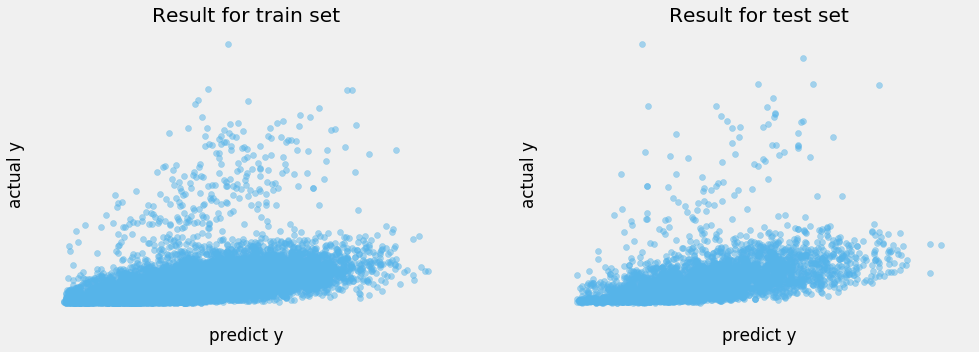

In [155]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,5))
ax1.scatter(x=reg.predict(X_train), y=y_train,alpha=0.5,color=sns.color_palette('colorblind')[-1])
ax1.set_title("Result for train set")
ax1.set_xlabel('predict y')
ax1.set_ylabel('actual y')
ax1.set_xticklabels('')
ax1.set_yticklabels('')
ax1.grid(False)

ax2.scatter(x=reg.predict(X_test), y=y_test, alpha=0.5,color=sns.color_palette('colorblind')[-1])
ax2.set_title("Result for test set")
ax2.set_xlabel('predict y')
ax2.set_ylabel('actual y')
ax2.set_xticklabels('')
ax2.set_yticklabels('')
ax2.grid(False)
plt.savefig("./pic/reg_result.png", bbox_inches='tight',dpi=300)

In [156]:
betas = pd.DataFrame(reg.params, index=(np.delete(df.columns.values,1)), columns=['params'])
betas['t_value'] = reg.tvalues

In [157]:
betas

,params,t_value
income,0.090239,28.862177
gender_F,0.011744,8.124977
age_<30,0.001019,0.102767
age_31~45,0.004232,0.430030
age_46~60,0.000281,0.028700
age_61~80,0.001085,0.110705
age_>80,-0.000002,-0.000221
became_member_on_<2014,0.017504,1.739840
became_member_on_2014,0.044865,4.529131
became_member_on_2015,0.050825,5.151285


In [158]:
def split_betas(key):
    """
    split index of table of beta to variable name and value.
    for example, received_offer_F_9 should be split to received_offer and F_9.
    return series according key.
    """
    factor = betas.loc[[key.split("_")[0] in ind.split('_') for ind in betas.index]]['params']
    factor.index = factor.index.str.split("_").str[-1]
    return factor.rename(key)

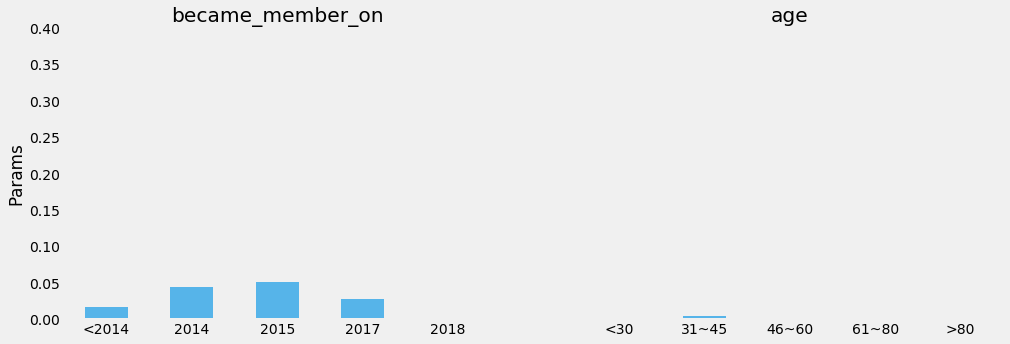

In [159]:
# age, become_member_on, gender ploting
betas_age =  split_betas('age')
betas_become_member = split_betas('became_member_on')
betas_gender = split_betas('gender')

fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
ax2 = betas_age.plot.bar(title='age',ax=ax2, rot=0, legend=False,  ylim=(0.,0.4), sharey=True,color=sns.color_palette('colorblind')[-1])
ax2.set_ylabel('Param weights')
ax2.grid(False)
ax1 = betas_become_member.plot.bar(title = 'became_member_on',ax=ax1, rot=0, legend=False, ylim=(0.,0.4),color=sns.color_palette('colorblind')[-1])
ax1.grid(False)
ax1.set_ylabel("Params")
plt.savefig('./pic/reg_result_demogriphic.png', bbox_inches='tight', dpi=300)

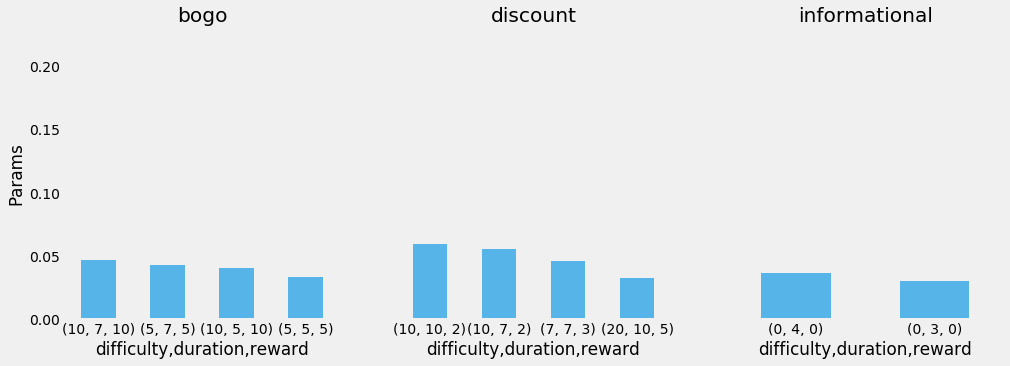

In [160]:
# offer type ploting
betas_offer = split_betas('offer')
betas_offer.index =  betas_offer.index.astype(int) - 1
betas_offer = pd.DataFrame(betas_offer).join(portfolio[['offer_type', 'difficulty','duration','reward']])
betas_offer = betas_offer.groupby(['offer_type', 'difficulty','duration','reward'])['offer'].sum()

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(15,5))

idx = pd.IndexSlice
ax2 = betas_offer.loc[idx['discount']].sort_values(ascending = False).plot.bar(title='discount', color=sns.color_palette('colorblind')[-1], ax=ax2, rot=0, ylim=(0.,0.23), sharey=True)
ax2.grid(False)

ax1 = betas_offer.loc[idx['bogo']].sort_values(ascending = False).plot.bar(title='bogo', color=sns.color_palette('colorblind')[-1], ax=ax1, rot=0, ylim=(0.,0.23))
ax1.set_ylabel("Params")
ax1.grid(False)

ax3 = betas_offer.loc[idx['informational']].sort_values(ascending = False).plot.bar(title='informational', color=sns.color_palette('colorblind')[-1], ax=ax3,rot=0,ylim=(0.,0.23), sharey=True)
ax3.grid(False)

plt.savefig('./pic/reg_result_response.png', bbox_inches='tight', dpi=300)

### 2.3.5.2 Random Forest model

In [161]:
regr = RandomForestRegressor(max_depth=7)
regr.fit(X_train,y_train)

RandomForestRegressor(max_depth=7)

In [162]:
    print(' train score: %.4f \n test score:  %.4f ' %(regr.score(X_train, y_train),regr.score(X_test, y_test)))

 train score: 0.2742 
 test score:  0.1595 


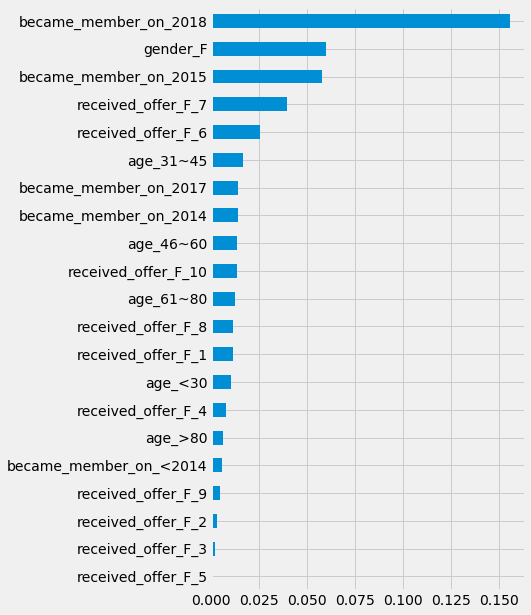

In [163]:
feature_importance =  pd.Series(regr.feature_importances_, index=(np.delete(df.columns.values,1))).astype(float)
feature_importance[1:].sort_values().plot.barh(figsize=(5,10))

### 2.3.5.3 SVR

In [164]:
svr = SVR()
svr.fit(X_train, y_train) 

SVR()

In [165]:
svr.score(X_train, y_train), svr.score(X_test, y_test)

(-0.09641612582427017, -0.09816066343342489)

In [166]:
model_dict={"Linear Regression": [r2_score(y_train,reg.predict(X_train)), r2_score(y_test,reg.predict(X_test))],
                  "Random Forest Regression":  [r2_score(y_train,regr.predict(X_train)), r2_score(y_test,regr.predict(X_test))],
                  "Supported Vector Rregreesion":  [r2_score(y_train,svr.predict(X_train)), r2_score(y_test,svr.predict(X_test))],
           }

In [167]:
pd.DataFrame(model_dict, index=['R2_train', 'R2_test']).round(2)

,Linear Regression,Random Forest Regression,Supported Vector Rregreesion
R2_train,0.21,0.27,-0.1
R2_test,0.20,0.16,-0.1
